In [11]:
# 1. Mount Google Drive to access and manage files from colab
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***Installing and Loading Important Libraries***

In [12]:
# 2. Install necessary libraries and import modules for geospatial data processing, deep learning, and visualization

# Install
!pip install rasterio tqdm

# Import
import rasterio

# Provides fucntions for interacting with Operating system
import os

# For efficient numerical operations and handling arrays
import numpy as np

# Displaying progress bars in loops
from tqdm import tqdm

# For working with raster datasets, commonly used with satellite imagery or geospatial data.
import rasterio

# Class to read/write subsets (windows) of raster data efficiently
from rasterio.windows import Window

# For building and training deep learning models
import tensorflow as tf

# For defining layers and models
from tensorflow.keras import layers, models, regularizers

# For image feature extraction or transfer learning
from tensorflow.keras.applications import VGG16

# Plotting and visualizing data, images and graphs
import matplotlib.pyplot as plt

# Import Mean Intersection over Union metric (used to evaluate segmentation performance)
from tensorflow.keras.metrics import MeanIoU

# Import EarlyStopping callback (stops training automatically when validation performance stops improving)
from tensorflow.keras.callbacks import EarlyStopping



***PATCH CREATION***

In [13]:
# 3 Paths to Sentinel-1 image, mask, label, and output patch directories

# Input data path
image_path = "/content/drive/MyDrive/Deep_Learning/S1_VV_VH_fullSeaShips.tif"  # VV+VH SAR image
mask_path  = "/content/drive/MyDrive/Deep_Learning/LabelFinal.tif"             # Binary ship mask

# Output directories for saving extracting patches
output_img_dir = "/content/drive/MyDrive/Deep_Learning/Patches/images"
output_mask_dir = "/content/drive/MyDrive/Deep_Learning/Patches/masks"

# Create output directories if they dont already exist
os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

# Size of each extracted patch (64x64 pixels)
patch_size = 64



# 4. Patch Extraction

# Open the sentinel-1 image and mask using rasterio
img_src = rasterio.open(image_path) # SAR image (2 channels: VV + VH)
mask_src = rasterio.open(mask_path) # Binary mask (1 = ship, 0 = water (background))

# Ensure the image and mask dimensions match
assert img_src.width == mask_src.width and img_src.height == mask_src.height, "Image and mask size mismatch"

count = 0 # Counter to keep track of how many patches are saved

# Loop over the image (row-wise-i, column-wise-j)
for i in tqdm(range(0, img_src.height, patch_size)): # iterate over rows
    for j in range(0, img_src.width, patch_size): # iterate ove columns

        # Define a window-subsection of the raster
        window = Window(j, i, patch_size, patch_size)

        # checking the wondow stays within image boundaries
        if (j + patch_size <= img_src.width) and (i + patch_size <= img_src.height):

            # Read corresponding mask patch (only 1 band)
            img_patch = img_src.read([1, 2], window=window)   # VV + VH
           # Read corresponding mask patch
            mask_patch = mask_src.read(1, window=window)

            # Skip empty patches (where mask =  0 everywhere, no shps)
            if np.sum(mask_patch) == 0:
                continue

            # Get georeferncing transform for thius patch
            img_transform = rasterio.windows.transform(window, img_src.transform)
            mask_transform = rasterio.windows.transform(window, mask_src.transform)

            # Save image patch
            img_patch_path = os.path.join(output_img_dir, f"patch_{count}.tif")
            with rasterio.open(
                img_patch_path,         # file name
                "w",                    # write name
                driver="GTiff",         # GeoTIFF format
                height=patch_size,      # Patch height
                width=patch_size,       # Patch width
                count=2,                # number of bands (VV + VH)
                dtype=img_patch.dtype,  # data type matches original
                crs=img_src.crs,        # Coordinate reference system
                transform=img_transform # Spatial transform for patch
            ) as dst:
                dst.write(img_patch)   # Write the 2-bands image patch

            # Save mask patch
            mask_patch_path = os.path.join(output_mask_dir, f"patch_{count}.tif")
            with rasterio.open(
                mask_patch_path,
                "w",
                driver="GTiff",
                height=patch_size,
                width=patch_size,
                count=1,
                dtype=mask_patch.dtype,
                crs=mask_src.crs,
                transform=mask_transform
            ) as dst:
                dst.write(mask_patch, 1)

            count += 1

print(f"Finished! Saved {count} patches of size {patch_size}x{patch_size}")

100%|██████████| 56/56 [00:17<00:00,  3.12it/s]

Finished! Saved 242 patches of size 64x64


***PREPROCESSING***

In [14]:
# 3. Prepare TF Datasets

# List all image and mask patches and sort them to keep correspondence
images = sorted([os.path.join(output_img_dir, f) for f in os.listdir(output_img_dir)])      # List of image paths
masks  = sorted([os.path.join(output_mask_dir, f) for f in os.listdir(output_mask_dir)])    # List of corresponding mask paths

# Combine images and masks into a single array for shuffling
data = np.column_stack((images, masks))                                                      # shape
np.random.shuffle(data)                                                                      # shuffle rows to randomize

# Train/validation split
prop = 0.8    # 80% for training and 20% for validation
training, testing = np.split(data, [int(prop*len(data))])                                    # Split array into train/test
print("Training samples:", len(training), "Validation samples:", len(testing))               # print counts

# Functions to read TIFF patches
def read_tiff(img_path, mask_path):
    # Read SAR image
    with rasterio.open(img_path.decode('utf-8')) as src:
        vv = np.clip(src.read(1).astype(np.float32), -25, 10)                                 # VV band clipped to [-25,10]
        vh = np.clip(src.read(2).astype(np.float32), -25, 10)                                 # VH band clipped t0 [-25, 10]
        img = np.stack([vv, vh], axis=-1)                                                     # stack VV and VH into 2-channel
        img = (img + 25.0)/35.0  # normalize to 0-1                                           # normalize to [0,1]
    # Read mask
    with rasterio.open(mask_path.decode('utf-8')) as src:
        mask = src.read(1).astype(np.float32)                                                 # read single-band mask
        if np.max(mask) > 0:
            mask /= np.max(mask)                                                              # normalize mask to 0-1
        mask = np.expand_dims(mask, axis=-1)                                                  # add channel dimension
    return img, mask                                                                          # return (image, mask) pair

# Tensorflow wrapper tp convert numpy function to TF graph
def decode_tiff(img_path, mask_path):
    img, mask = tf.numpy_function(read_tiff, [img_path, mask_path], [tf.float32, tf.float32]) # call read_tiff
    img.set_shape([64,64,2])                                                                  # set image shape (H,W,C)
    mask.set_shape([64,64,1])                                                                 # set mask shape (H,W,1)

    # return tensors
    return img, mask

# Create datasets
batch_size = 10
train_ds = tf.data.Dataset.from_tensor_slices((training[:,0], training[:,1]))                # Create dataset
train_ds = train_ds.map(decode_tiff, num_parallel_calls=tf.data.AUTOTUNE)                    # decade TIFF files

# Augmentation
def augment(img, mask):
    img = tf.image.random_brightness(img, 0.3)                                              # random brightness adjustment
    img = tf.image.random_contrast(img, 0.8, 1.1)                                           # random contrast adjustment
    img = tf.clip_by_value(img, 0, 1)                                                       # clip values to [0,1]
    img = tf.image.flip_left_right(img)                                                     # random horizontal flip
    img = tf.image.flip_up_down(img)                                                      # random verttical flip
    mask = tf.image.flip_left_right(mask)                                                   # flip mask horizontally
    mask = tf.image.flip_up_down(mask)                                                    # flip mask verically
    return img, mask                                                                        # return augmented image + mask

# Apply augmentation, shuffle, batch, and prefetch for training
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)                      # apply augmentation
train_ds = train_ds.shuffle(len(training)).batch(batch_size).prefetch(tf.data.AUTOTUNE)    # shuffle, batch, prefetch

# Create validation dataset (no augmentation)
val_ds = tf.data.Dataset.from_tensor_slices((testing[:,0], testing[:,1]))                  # create dataset from validation paths
val_ds = val_ds.map(decode_tiff, num_parallel_calls=tf.data.AUTOTUNE)                      # decode TIFF files
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)                               # Batch and prefetch

Training samples: 193 Validation samples: 49


***VGG16***


In [15]:

# 1. Define Dice loss function
def dice_loss(y_true, y_pred, smooth=1e-6):

    y_true_f = tf.keras.backend.flatten(y_true)                                                   # flatten ground truth
    y_pred_f = tf.keras.backend.flatten(y_pred)                                                   # flatten predictions
    intersection = tf.reduce_sum(y_true_f * y_pred_f)  # overlap
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# Combined BCE + Dice loss
def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return bce + d_loss

# 2. Define metrics: IoU and Dice coefficient
def iou_metric(y_true, y_pred, threshold=0.5):
    y_pred_bin = tf.cast(y_pred > threshold, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred_bin)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred_bin) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)                                                    # Flatten ground truth
    y_pred_f = tf.keras.backend.flatten(y_pred)                                                    # Flatten predictions
    y_pred_bin = tf.cast(y_pred_f > 0.5, tf.float32)                                               # Binarize predictions
    intersection = tf.reduce_sum(y_true_f * y_pred_bin)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_bin) + smooth)

# 3. Build VGG16-U-Net model
def build_vgg16_unet(input_shape=(64,64,2)):
    inputs = layers.Input(shape=input_shape)

    # Convert 2-channel SAR to 3 channels for VGG16
    x = layers.Conv2D(3, (1,1), padding="same")(inputs)

    # Load pretrained VGG16 encoder
    vgg = VGG16(weights="imagenet", include_top=False, input_shape=(64,64,3))

    # Extract skip connections
    s1 = vgg.get_layer("block1_conv2").output                                                    # 64x64x64
    s2 = vgg.get_layer("block2_conv2").output                                                    # 32x32x128
    s3 = vgg.get_layer("block3_conv3").output                                                    # 16x16x256
    s4 = vgg.get_layer("block4_conv3").output                                                    # 8x8x512
    b  = vgg.get_layer("block5_conv3").output                                                    # 4x4x512 (bottleneck)

    # Encoder model to extract features
    encoder = models.Model(vgg.input, [s1, s2, s3, s4, b])
    s1, s2, s3, s4, b = encoder(x)

    # Decoder Stage 1 (from bottleneck 4x4x512 - 8x8x512)
    d1 = layers.Conv2DTranspose(512, (3,3), strides=2, padding="same")(b)                        # 8x8x512
    d1 = layers.Concatenate()([d1, s4])                                                          # concat with skip s4 (8x8x512) - 8x8x1024
    d1 = layers.Conv2D(512, (3,3), activation="relu", padding="same",
                   kernel_regularizer=regularizers.l2(1e-4))(d1)                                 # 8x8x512
    d1 = layers.Dropout(0.3)(d1)
    d1 = layers.Conv2D(256, (3,3), activation="relu", padding="same",
                   kernel_regularizer=regularizers.l2(1e-4))(d1)                                 # 8x8x256

    # Decoder Stage 2 (8x8x256 - 16x16x256)
    d2 = layers.Conv2DTranspose(256, (3,3), strides=2, padding="same")(d1)                       # 16x16x256
    d2 = layers.Concatenate()([d2, s3])                                                          # concat with skip s3 (16x16x256) - 16x16x512
    d2 = layers.Conv2D(256, (3,3), activation="relu", padding="same",
                   kernel_regularizer=regularizers.l2(1e-4))(d2)                                 # 16x16x256
    d2 = layers.Dropout(0.3)(d2)
    d2 = layers.Conv2D(128, (3,3), activation="relu", padding="same",
                   kernel_regularizer=regularizers.l2(1e-4))(d2)                                 # 16x16x128

    # Decoder Stage 3 (16x16x128 - 32x32x128)
    d3 = layers.Conv2DTranspose(128, (3,3), strides=2, padding="same")(d2)                       # 32x32x128
    d3 = layers.Concatenate()([d3, s2])                                                          # concat with skip s2 (32x32x128) - 32x32x256
    d3 = layers.Conv2D(128, (3,3), activation="relu", padding="same",
                   kernel_regularizer=regularizers.l2(1e-4))(d3)                                 # 32x32x128
    d3 = layers.Dropout(0.3)(d3)
    d3 = layers.Conv2D(64, (3,3), activation="relu", padding="same",
                   kernel_regularizer=regularizers.l2(1e-4))(d3)                                 # 32x32x64

    # Decoder Stage 4 (32x32x64 - 64x64x64)
    d4 = layers.Conv2DTranspose(64, (3,3), strides=2, padding="same")(d3)                        # 64x64x64
    d4 = layers.Concatenate()([d4, s1])                                                          # concat with skip s1 (64x64x64) - 64x64x128
    d4 = layers.Conv2D(64, (3,3), activation="relu", padding="same",
                   kernel_regularizer=regularizers.l2(1e-4))(d4)                                 # 64x64x64
    d4 = layers.Dropout(0.3)(d4)
    d4 = layers.Conv2D(32, (3,3), activation="relu", padding="same",
                   kernel_regularizer=regularizers.l2(1e-4))(d4)                                 # 64x64x32

    # Output layer - binary mask
    outputs = layers.Conv2D(1, (1,1), activation="sigmoid")(d4)                                  # 64x64x1


    return models.Model(inputs, outputs)

# 4. Build and compile model
model = build_vgg16_unet(input_shape=(64,64,2))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=bce_dice_loss,
    metrics=[
        "accuracy",
        MeanIoU(num_classes=2, name="mean_iou"),                                               # Named for easier plotting
        dice_coef                                                                              # Dice coefficient metric
    ]
)

model.summary()

# 5. Train with EarlyStopping
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop]
)

# 6. Save trained model
model.save("/content/drive/MyDrive/Deep_Learning/final_ship_unet_model.keras")


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 64, 64, 2) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64, 3) │          9 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_4        │ [(None, 64, 64,   │ 14,714,688 │ conv2d_20[0][0]   │
│ (Functional)        │ 64), (None, 32,   │            │                   │
│                     │ 32, 128), (None,  │            │                   │
│                     │ 16, 16, 256),     │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 512), (None, 4,   │            │                   │
│                     │ 4, 512)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 8, 8, 512) │  2,359,808 │ functional_4[0][… │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 8, 8,      │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 1024)             │            │ functional_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 8, 8, 512) │  4,719,104 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 8, 8, 512) │          0 │ conv2d_21[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 8, 8, 256) │  1,179,904 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_9  │ (None, 16, 16,    │    590,080 │ conv2d_22[0][0]   │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ functional_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 16, 16,    │  1,179,904 │ concatenate_9[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 16, 16,    │    295,040 │ dropout_9[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_10 │ (None, 32, 32,    │    147,584 │ conv2d_24[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ functional_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │    295,040 │ concatenate_10[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 25,684,170 (97.98 MB)

 Trainable params: 25,684,170 (97.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 891ms/step - accuracy: 0.6615 - dice_coef: 0.0233 - loss: 1.8055 - mean_iou: 0.4943 - val_accuracy: 0.9897 - val_dice_coef: 0.0024 - val_loss: 1.2155 - val_mean_iou: 0.4948
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.9891 - dice_coef: 0.0314 - loss: 1.1711 - mean_iou: 0.4945 - val_accuracy: 0.9931 - val_dice_coef: 0.5066 - val_loss: 0.7330 - val_mean_iou: 0.4948
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.9932 - dice_coef: 0.6303 - loss: 0.6211 - mean_iou: 0.4948 - val_accuracy: 0.9951 - val_dice_coef: 0.7538 - val_loss: 0.4165 - val_mean_iou: 0.4948
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.9948 - dice_coef: 0.7691 - loss: 0.4093 - mean_iou: 0.5087 - val_accuracy: 0.9941 - val_dice_coef: 0.7385 - val_loss: 0.4300 - val_mean_iou: 0.5129
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.9953 - dice_coef: 0.7943 - loss: 0.3691 - mean_iou: 0.5242 - val_accuracy: 0.

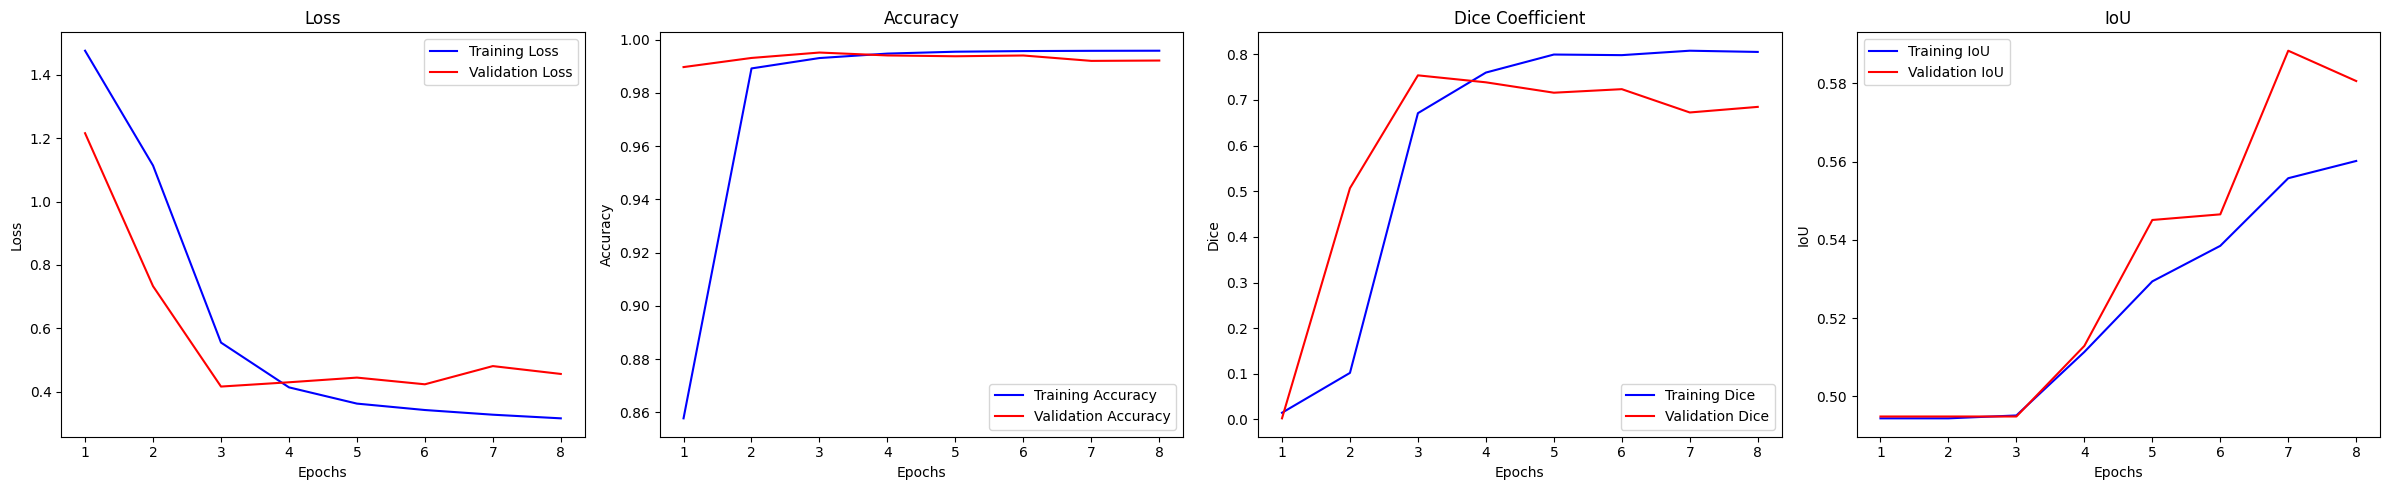

In [16]:
# Plotting Training vs. Validation Metrics Across Epochs
# Extract metrics from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

dice = history.history['dice_coef']
val_dice = history.history['val_dice_coef']

iou = history.history['mean_iou']
val_iou = history.history['val_mean_iou']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(24, 5))  # wider figure for 4 plots in a row

# Plot Loss
plt.subplot(1, 4, 1)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 4, 2)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Dice coefficient
plt.subplot(1, 4, 3)
plt.plot(epochs, dice, 'b-', label='Training Dice')
plt.plot(epochs, val_dice, 'r-', label='Validation Dice')
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()

# Plot IoU
plt.subplot(1, 4, 4)
plt.plot(epochs, iou, 'b-', label='Training IoU')
plt.plot(epochs, val_iou, 'r-', label='Validation IoU')
plt.title('IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()  # adjust spacing
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step


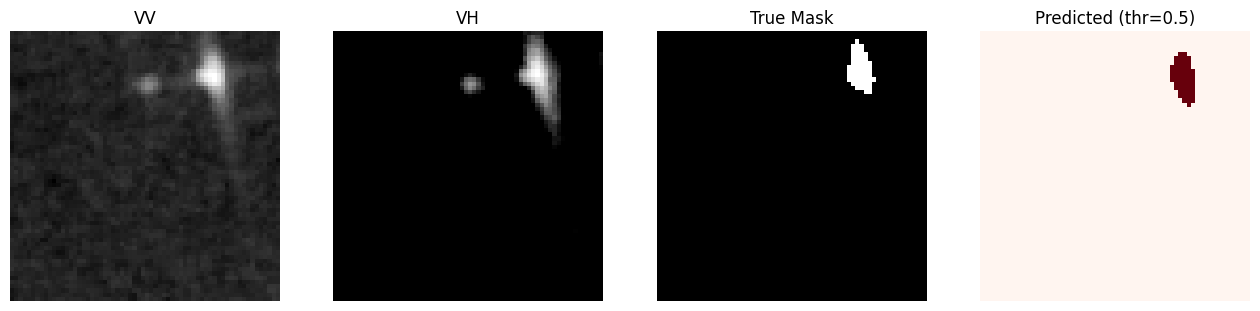

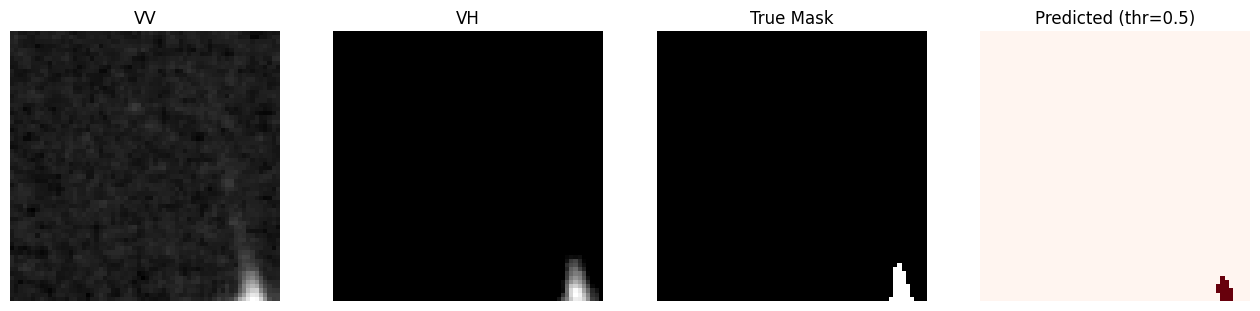

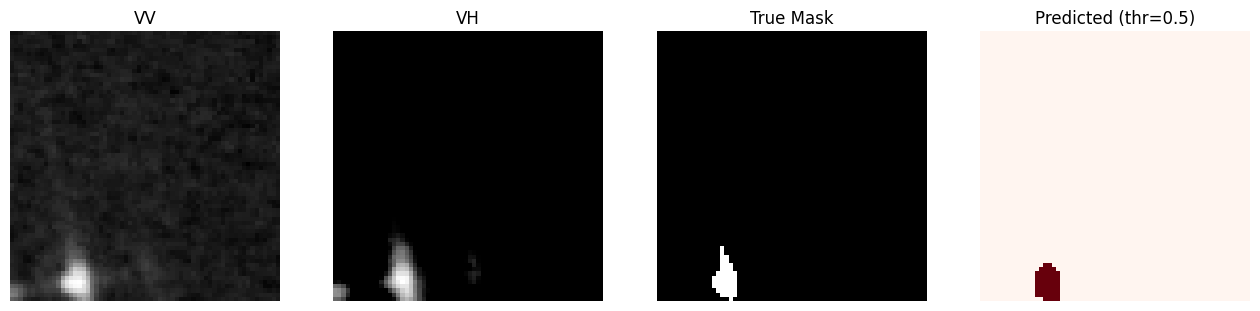

In [17]:
#  Visualize Predictions on Validation Set

def visualize_predictions(model, val_dataset, num_batches=1, num_images=3, threshold=0.5):
    batch_count = 0
    for image_batch, mask_batch in val_dataset.take(num_batches):
        raw_preds = model.predict(image_batch)
        preds = (raw_preds > threshold).astype(np.uint8)

        for i in range(min(num_images, len(image_batch))):
            fig, axes = plt.subplots(1,4, figsize=(16,4))
            axes[0].imshow(image_batch[i,:,:,0], cmap='gray')
            axes[0].set_title("VV")
            axes[0].axis('off')

            axes[1].imshow(image_batch[i,:,:,1], cmap='gray')
            axes[1].set_title("VH")
            axes[1].axis('off')

            axes[2].imshow(mask_batch[i,:,:,0], cmap='gray')
            axes[2].set_title("True Mask")
            axes[2].axis('off')

            axes[3].imshow(preds[i,:,:,0], cmap='Reds')
            axes[3].set_title(f"Predicted (thr={threshold})")
            axes[3].axis('off')

            plt.show()
        batch_count += 1

# Run visualization
visualize_predictions(model, val_ds, num_batches=1, num_images=3, threshold=0.5)

U-Net

In [18]:
# 1. Define Dice Loss + BCE
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return bce + d_loss

# 2. Metrics: IoU and Dice
def iou_metric(y_true, y_pred, threshold=0.5):
    y_pred_bin = tf.cast(y_pred > threshold, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred_bin)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred_bin) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

def dice_coef(y_true, y_pred, smooth=1):
    y_pred_bin = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred_bin)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred_bin) + smooth)

# 3. Build U-Net with Dropout and L2 Regularization
def unet_model(input_shape=(64, 64, 2), dropout_rate=0.3, l2_reg=1e-4):
    reg = regularizers.l2(l2_reg)
    inputs = layers.Input(input_shape)                                                                  # (64, 64, 2) - 2-channel SAR input (VV+VH)

    #  Encoder
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=reg)(inputs)    # (64, 64, 32)
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=reg)(c1)        # (64, 64, 32)
    p1 = layers.MaxPooling2D((2,2))(c1)                                                                 # (32, 32, 32)
    p1 = layers.Dropout(dropout_rate)(p1)

    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=reg)(p1)        # (32, 32, 64)
    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=reg)(c2)        # (32, 32, 64)
    p2 = layers.MaxPooling2D((2,2))(c2)                                                                 # (16, 16, 64)
    p2 = layers.Dropout(dropout_rate)(p2)

    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=reg)(p2)      # (16, 16, 128)
    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=reg)(c3)      # (16, 16, 128)
    p3 = layers.MaxPooling2D((2,2))(c3)                                                                # (8, 8, 128)
    p3 = layers.Dropout(dropout_rate)(p3)

    # Bottleneck
    b1 = layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=reg)(p3)      # (8, 8, 256)
    b1 = layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=reg)(b1)      # (8, 8, 256)
    b1 = layers.Dropout(dropout_rate)(b1)

    # Decoder
    u3 = layers.UpSampling2D((2,2))(b1)                                                               # (16, 16, 256)
    u3 = layers.Concatenate()([u3, c3])                                                               # (16, 16, 384) ← concat with skip connection
    c4 = layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=reg)(u3)     # (16, 16, 128)
    c4 = layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=reg)(c4)     # (16, 16, 128)
    c4 = layers.Dropout(dropout_rate)(c4)

    u2 = layers.UpSampling2D((2,2))(c4)                                                               # (32, 32, 128)
    u2 = layers.Concatenate()([u2, c2])                                                               # (32, 32, 192)
    c5 = layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=reg)(u2)      # (32, 32, 64)
    c5 = layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=reg)(c5)      # (32, 32, 64)
    c5 = layers.Dropout(dropout_rate)(c5)

    u1 = layers.UpSampling2D((2,2))(c5)                                                               # (64, 64, 64)
    u1 = layers.Concatenate()([u1, c1])                                                               # (64, 64, 96)
    c6 = layers.Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=reg)(u1)      # (64, 64, 32)
    c6 = layers.Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=reg)(c6)      # (64, 64, 32)
    c6 = layers.Dropout(dropout_rate)(c6)

    # Output
    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c6)                                       # (64, 64, 1) - binary mask

    return models.Model(inputs, outputs)

# 4. Compile Model
learning_rate = 1e-4                                                                                  # adjustable
model = unet_model(input_shape=(64, 64, 2), dropout_rate=0.3, l2_reg=1e-4)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=bce_dice_loss,
    metrics=["accuracy", iou_metric, dice_coef]
)

# 5. Train Model
EPOCHS = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5)
    ]
)


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 890ms/step - accuracy: 0.5882 - dice_coef: 0.0368 - iou_metric: 0.0187 - loss: 1.7916 - val_accuracy: 0.9897 - val_dice_coef: 0.0024 - val_iou_metric: 2.4391e-09 - val_loss: 1.4081 - learning_rate: 1.0000e-04
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.9858 - dice_coef: 0.0064 - iou_metric: 0.0023 - loss: 1.3396 - val_accuracy: 0.9897 - val_dice_coef: 0.0024 - val_iou_metric: 2.4391e-09 - val_loss: 1.2956 - learning_rate: 1.0000e-04
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9879 - dice_coef: 0.0026 - iou_metric: 2.5810e-04 - loss: 1.2684 - val_accuracy: 0.9897 - val_dice_coef: 0.0024 - val_iou_metric: 2.4391e-09 - val_loss: 1.2145 - learning_rate: 1.0000e-04
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9893 - dice_coef: 0.0033 - iou_metric: 5.0058e-04 - loss: 1.2007 - val_accuracy: 0.9897 - val_dice_coef: 0.0024 - val_iou_metric: 2.4391e-09 - val_loss: 1.2068 - learning_rate: 1.000

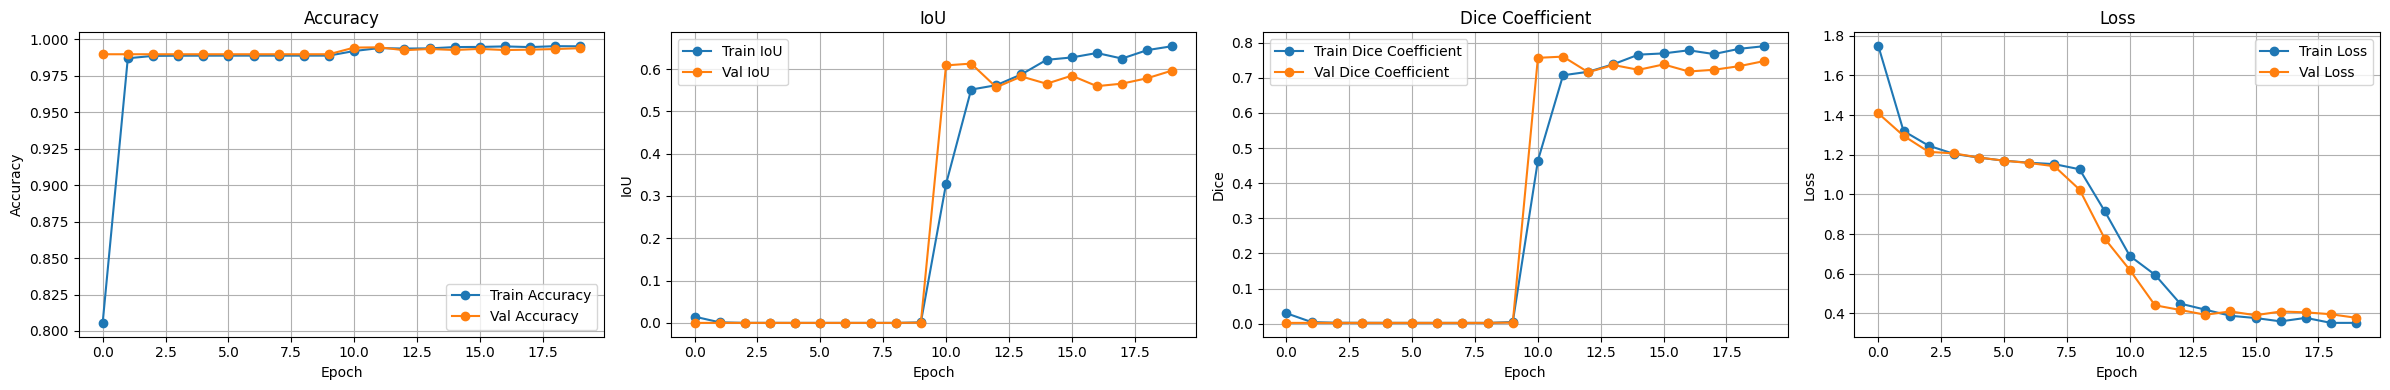

In [19]:
def plot_training_history(history, layout="horizontal", save_path=None):
    metrics = ["accuracy", "iou_metric", "dice_coef", "loss"]
    titles = ["Accuracy", "IoU", "Dice Coefficient", "Loss"]
    ylabels = ["Accuracy", "IoU", "Dice", "Loss"]

    if layout == "horizontal":
        plt.figure(figsize=(24, 4))                                                       # wide layout
        nrows, ncols = 1, 4
    else:
        plt.figure(figsize=(6, 20))                                                       # tall layout
        nrows, ncols = 4, 1

    for i, metric in enumerate(metrics, 1):
        plt.subplot(nrows, ncols, i)
        plt.plot(history.history[metric], 'o-', label=f"Train {titles[i-1]}")
        plt.plot(history.history[f"val_{metric}"], 'o-', label=f"Val {titles[i-1]}")
        plt.title(titles[i-1])
        plt.xlabel("Epoch")
        plt.ylabel(ylabels[i-1])
        plt.legend()
        plt.grid(True)

    plt.tight_layout()


    plt.show()


# Example usage after training
plot_training_history(history, layout="horizontal", save_path="training_history.png")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Sample 0: Raw prediction min=0.000, max=1.000


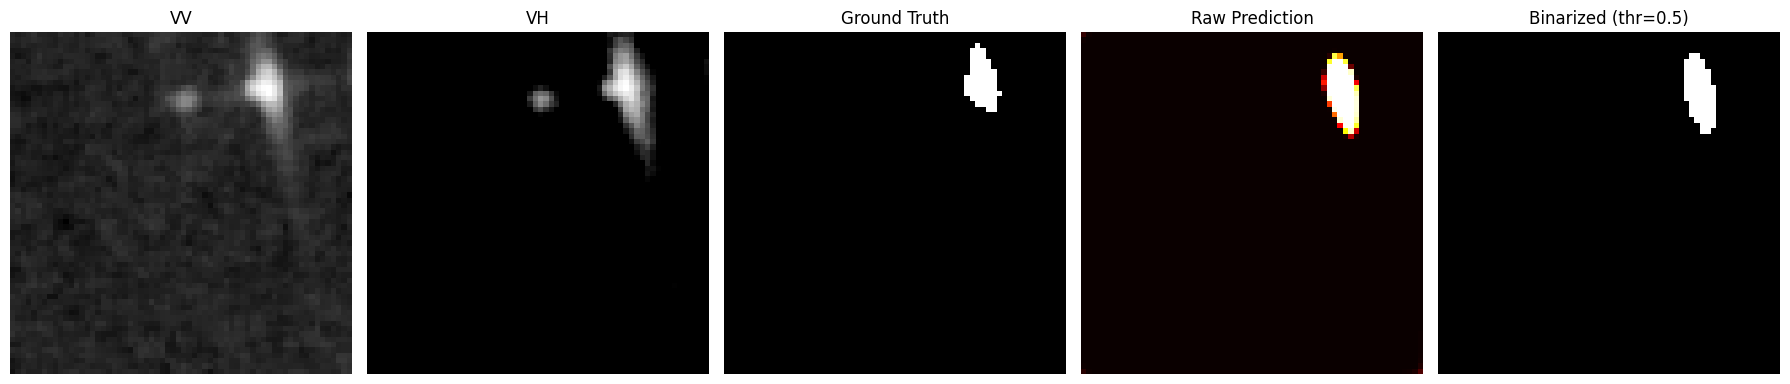

Sample 1: Raw prediction min=0.000, max=0.996


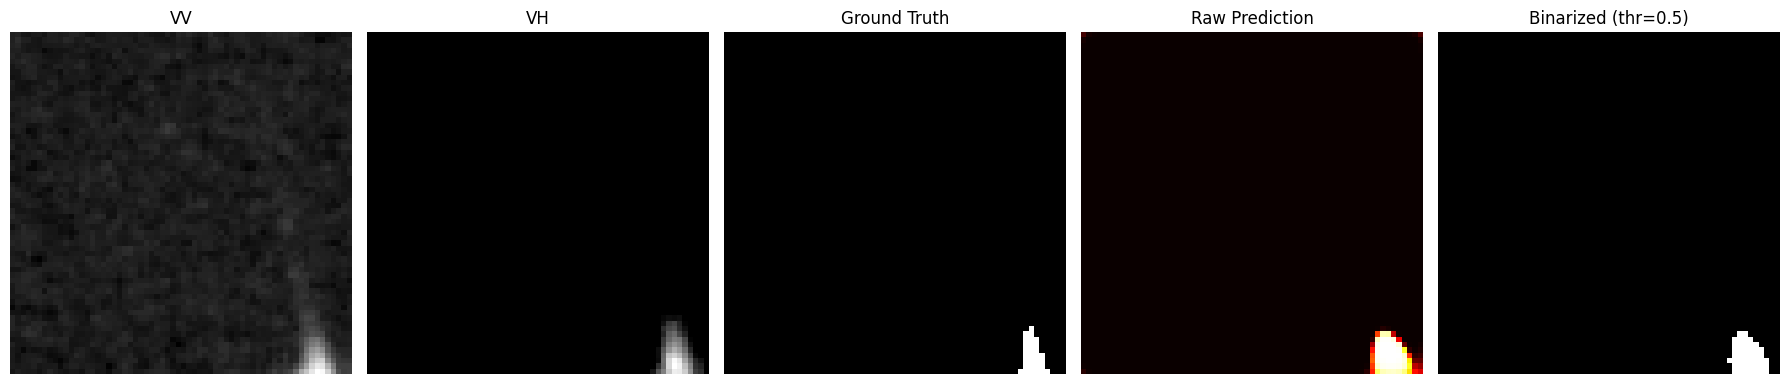

Sample 2: Raw prediction min=0.000, max=1.000


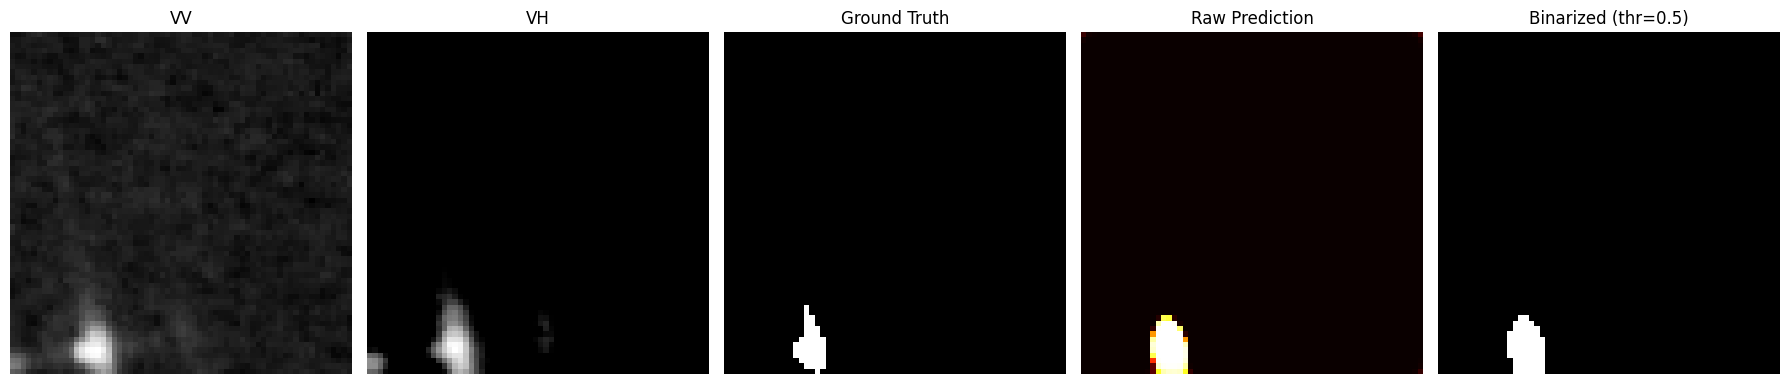

In [20]:
# 7. Visualize Predictions
def visualize_predictions(model, dataset, num_samples=3, threshold=0.5, save_images=False):
    for images, masks in dataset.take(1):                                                                             # take one batch
        preds = model.predict(images)

        for i in range(min(num_samples, len(images))):
            vv = images[i, :, :, 0]
            vh = images[i, :, :, 1]
            true_mask = masks[i, :, :, 0]
            pred_mask = preds[i, :, :, 0]
            pred_bin = (pred_mask > threshold).astype(np.uint8)

            print(f"Sample {i}: Raw prediction min={pred_mask.min():.3f}, max={pred_mask.max():.3f}")

            plt.figure(figsize=(18, 4))
            plt.subplot(1, 5, 1); plt.imshow(vv, cmap='gray'); plt.title("VV"); plt.axis("off")
            plt.subplot(1, 5, 2); plt.imshow(vh, cmap='gray'); plt.title("VH"); plt.axis("off")
            plt.subplot(1, 5, 3); plt.imshow(true_mask, cmap='gray'); plt.title("Ground Truth"); plt.axis("off")
            plt.subplot(1, 5, 4); plt.imshow(pred_mask, cmap='hot'); plt.title("Raw Prediction"); plt.axis("off")
            plt.subplot(1, 5, 5); plt.imshow(pred_bin, cmap='gray'); plt.title(f"Binarized (thr={threshold})"); plt.axis("off")

            plt.tight_layout()

            plt.show()

# Example usage:
visualize_predictions(model, val_ds, num_samples=3, threshold=0.5)